In [942]:
import os
import cv2
import numpy as np
import neurokit2 as nk

In [943]:
root = './UBFC_DATASET/DATASET_1/'
# root = '/content/drive/MyDrive/UBFC_DATASET/DATASET_1/'

dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]

dir_name = dirs[5]
vid_folder = os.path.join(root, dir_name)

gt_filename = os.path.join(vid_folder, 'gtdump.xmp')
if os.path.isfile(gt_filename):
    gt_data = np.genfromtxt(gt_filename, delimiter=',')
    gt_time = gt_data[:, 0] / 1000
    gt_hr = gt_data[:, 1]
    gt_trace = gt_data[:, 3]
else:
    gt_filename = os.path.join(vid_folder, 'ground_truth.txt')
    if os.path.isfile(gt_filename):
        gt_data = np.genfromtxt(gt_filename, delimiter=' ')
        gt_trace = gt_data[:, 0]
        gt_hr = gt_data[:, 1]
        gt_time = gt_data[:, 2]

gt_trace = (gt_trace - np.mean(gt_trace)) / np.std(gt_trace)

In [944]:
print("dir_name:", dir_name)
print("vid_folder:", vid_folder)
print("gt_trace shape:", gt_trace.shape)
print("gt_hr shape:", gt_hr.shape)
print("gt_time shape:", gt_time.shape)

dir_name: 7-gt
vid_folder: ./UBFC_DATASET/DATASET_1/7-gt
gt_trace shape: (5128,)
gt_hr shape: (5128,)
gt_time shape: (5128,)


In [945]:
vid_path = os.path.join(vid_folder, 'vid.avi')
vidObj = cv2.VideoCapture(vid_path)
face_list = []

fps = vidObj.get(cv2.CAP_PROP_FPS)
first_frame = True

while True:
    ret, frame = vidObj.read()
    if not ret:
        break
    if first_frame:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = cv2.CascadeClassifier('./haarcascade-frontalface-default.xml').detectMultiScale(frame_gray, 1.3, 5)
        x, y, w, h = faces[0]
        first_frame = False

    face = frame[y + 40:y + 60, x + 100:x + 130]
    face_list.append(face)

vidObj.release()
face_list = np.array(face_list)

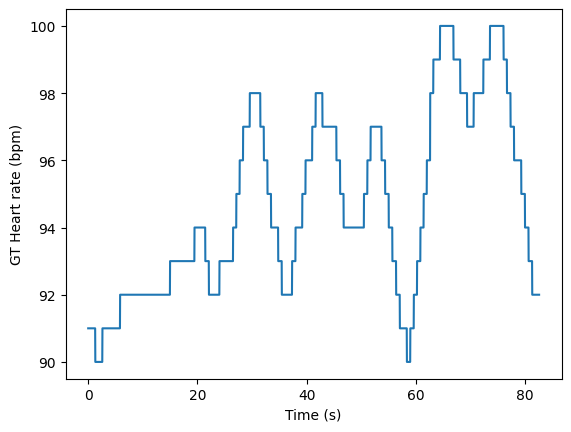

In [948]:
import matplotlib.pyplot as plt
plt.plot(gt_time, gt_hr)
plt.xlabel('Time (s)')
plt.ylabel('GT Heart rate (bpm)')
plt.show()

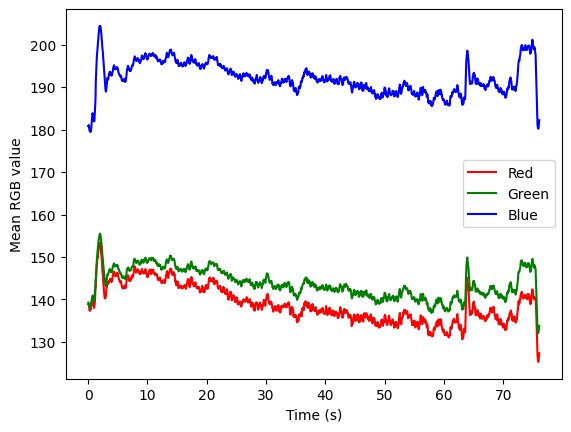

In [949]:
def plot_means(mean):
  plt.plot(gt_time[:mean.shape[0]]*2, mean[:,0],'r', label='Red')
  plt.plot(gt_time[:mean.shape[0]]*2, mean[:,1],'g', label='Green')
  plt.plot(gt_time[:mean.shape[0]]*2, mean[:,2],'b', label='Blue')
  plt.xlabel('Time (s)')
  plt.ylabel('Mean RGB value')
  plt.legend()
  plt.show()

# RGB means for the whole image

mean = np.zeros((len(face_list), 3), dtype=np.float32)
mean_r = np.float32(0.0)
mean_g = np.float32(0.0)
mean_b = np.float32(0.0)
for i,face in enumerate(face_list):
    mean_r = face[:, :, 0].mean()
    mean_g = face[:, :, 1].mean()
    mean_b = face[:, :, 2].mean()
    mean[i] = mean_r, mean_g, mean_b
plot_means(mean)

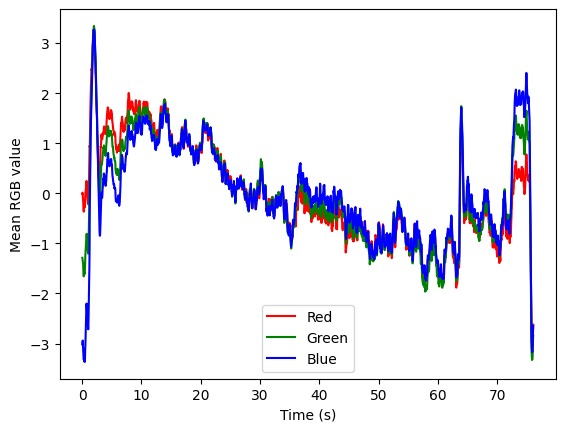

In [951]:
# Normalize RGB means

mean[:,0] = (mean[:,0] - np.average(mean[:,0]))/np.std(mean[:,0])
mean[:,1] = (mean[:,1] - np.average(mean[:,1]))/np.std(mean[:,1])
mean[:,2] = (mean[:,2] - np.average(mean[:,2]))/np.std(mean[:,2])
plot_means(mean)

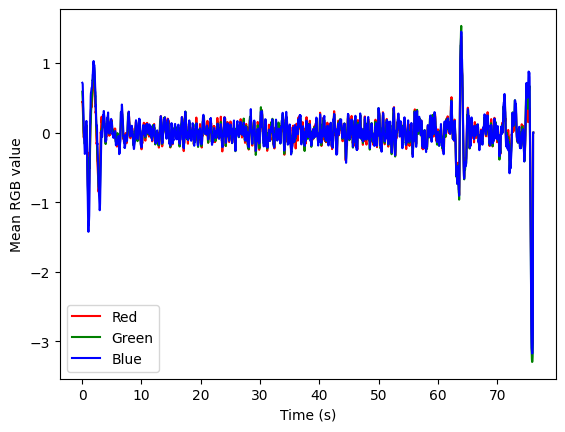

In [952]:
# Detrending means

detrended_mean = mean
detrended_mean[:,0] = nk.signal_detrend(mean[:,0], method="tarvainen2002", regularization=120)
detrended_mean[:,1] = nk.signal_detrend(mean[:,1], method="tarvainen2002", regularization=120)
detrended_mean[:,2] = nk.signal_detrend(mean[:,2], method="tarvainen2002", regularization=120)
plot_means(detrended_mean)

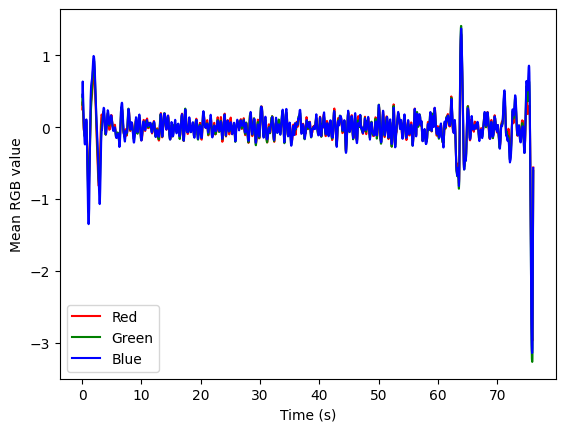

In [953]:
# Moving average filter

window_size = int(fps*0.18)
kernel = np.ones(window_size) / window_size
filtered_mean = detrended_mean
filtered_mean[:,0] = np.convolve(detrended_mean[:,0],kernel,'same')
filtered_mean[:,1] = np.convolve(detrended_mean[:,1],kernel,'same')
filtered_mean[:,2] = np.convolve(detrended_mean[:,2],kernel,'same')
plot_means(filtered_mean)

In [954]:
# Decomposition

from sklearn.decomposition import PCA, FastICA

transformer = FastICA(n_components = 3)
independent_signal = transformer.fit_transform(filtered_mean)

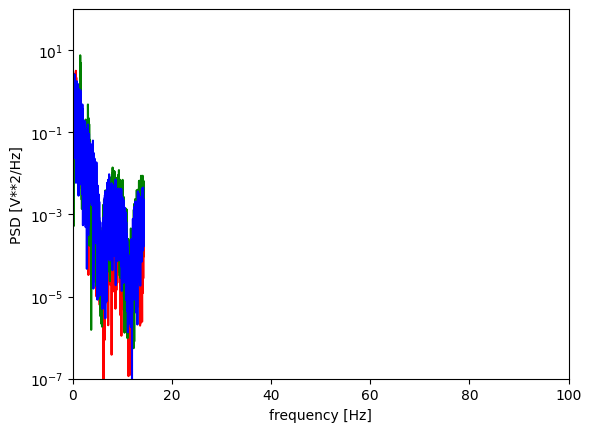

In [955]:
# Calculating PSD

from scipy.signal import periodogram
(f_r, S_r) = periodogram(independent_signal[:,0], fps, scaling='density')
(f_g, S_g) = periodogram(independent_signal[:,1], fps, scaling='density')
(f_b, S_b) = periodogram(independent_signal[:,2], fps, scaling='density')

plt.semilogy(f_r, S_r , 'r')
plt.semilogy(f_g, S_g, 'g')
plt.semilogy(f_b, S_b, 'b')
plt.ylim([1e-7, 1e2])
plt.xlim([0,100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [956]:
# Continuing with the signal that has max power

signal = independent_signal[:,np.argmax([max(S_r),max(S_g),max(S_b)])]

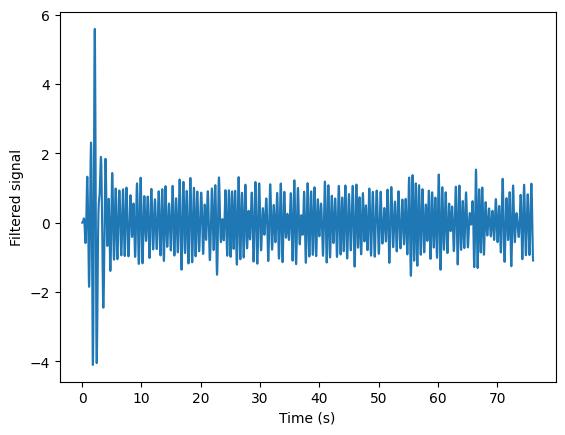

In [957]:
# Applying bandpass filter between 0.8 Hz and 2 Hz

import numpy as np
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

final_signal = butter_bandpass_filter(signal, 0.8, 2, fps, order=5)

plt.plot(gt_time[:final_signal.shape[0]]*2, final_signal)
plt.xlabel('Time (s)')
plt.ylabel('Filtered signal')
plt.show()

In [958]:
# Taking frequency with the highest power as the pulse signal

(f_r, S_r) = periodogram(final_signal, fps, scaling='density')

f = f_r[S_r.argmax()]

In [959]:
# Calculating heart rate

hr = 60 *f
print(hr)

91.76913723962743


In [960]:
len(final_signal)

2362

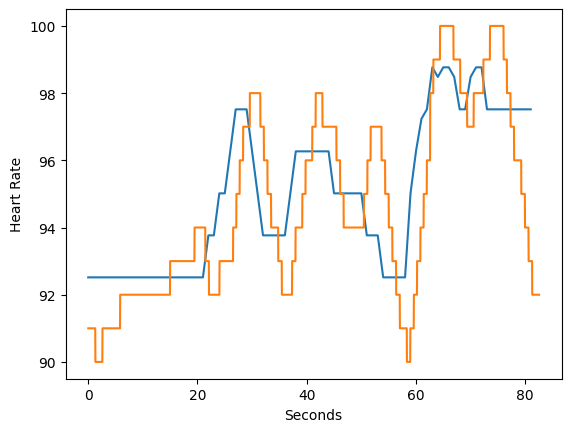

In [965]:
# Taking frequency with the highest power as the pulse signal

values = []

window = 6

lower_bound = window
upper_bound = int(final_signal.shape[0] / fps) - window

for i in range(lower_bound, upper_bound, 1):
    x = (final_signal[int((i - window) * fps):int((i + window) * fps)])
    (f_r, S_r) = periodogram(x, fps, nfft=len(x) * 4, scaling='density')

    f = f_r[S_r.argmax()]

    hr = 60 *f
    if i == window:
        values.extend([hr] * window)
        
    values.append(hr)


values.extend([values[-1]] * window)

import matplotlib.pyplot as plt

plt.plot(values)
plt.plot(gt_time, gt_hr)
plt.xlabel('Seconds')
plt.ylabel('Heart Rate')
plt.show()

In [962]:
print(np.mean(values))
print(np.mean(gt_hr))

95.03353765072814
94.6833073322933
